In [1]:
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

C:\Users\xinyu\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# (a)

In [2]:
biden = pd.read_csv('biden.csv', sep=',')
y = biden['biden'].values
X = biden[['female', 'age', 'educ', 'dem', 'rep']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)
hit_tree = DecisionTreeRegressor(min_samples_leaf=10)
hit_tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

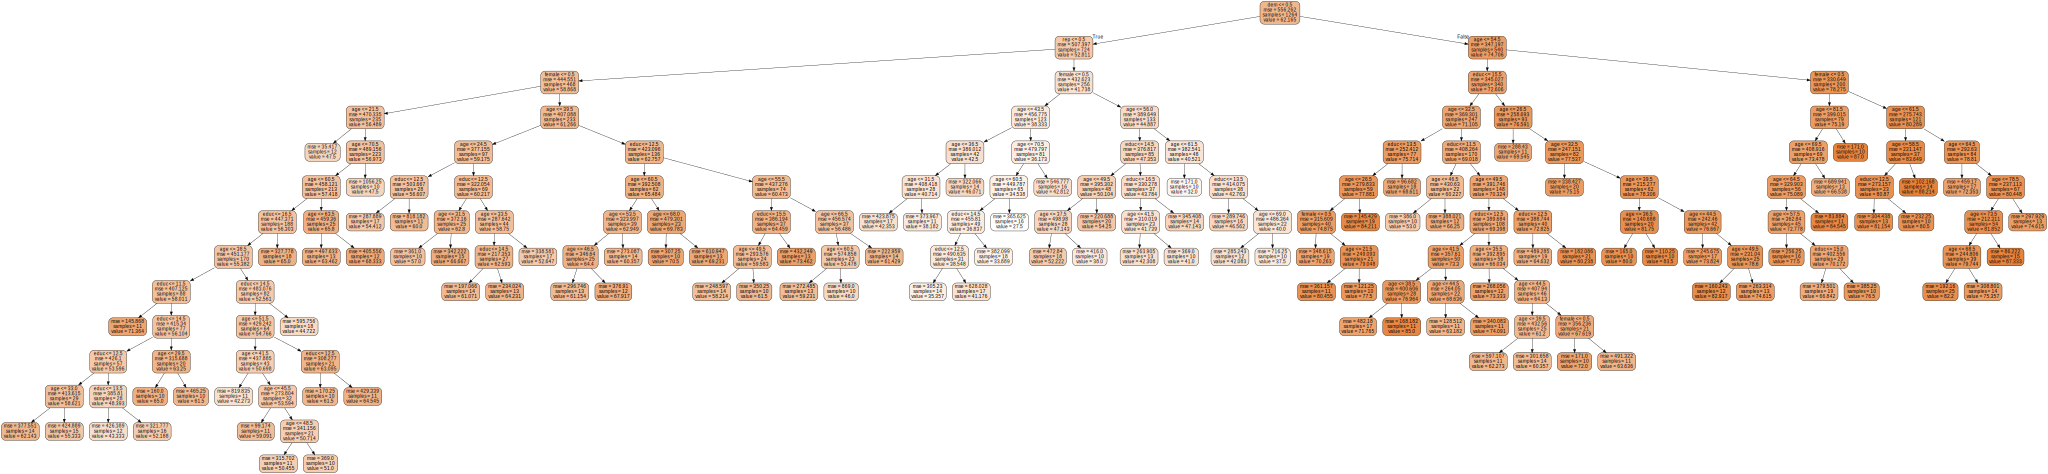

In [3]:
hit_tree_viz = export_graphviz(
    hit_tree,
    out_file=None,
    feature_names = ['female', 'age', 'educ', 'dem', 'rep'],
    rounded=True,
    filled=True,
)

graph = graphviz.Source(hit_tree_viz)
graph.render('hit_tree_viz')
graph

In [4]:
y_pred = hit_tree.predict(X_test)
MSE1 = mean_squared_error(y_test, y_pred)
print('MSE=', MSE1)

MSE= 432.9810841475085


### The default model in python is rather complicated. So I will just talk about first three layers, and the please see  viz.pdf for more details. The first branch if if people are democrat or not. For non-democrats, not surprising, if they are republican they like Biden less compared to central voters. For Repuplican, Female like Biden slightly more than man. For non-Repuplican, it's the same that female like Biden more.

### Democrats love Biden more than non-Democrats. If they are Democrat, we will come to the second layer, then age matters. Older generation in Democrats love Biden more. For younger generation, females love Biden more, for younger generation people those who have more than 15.5 years love Biden more.  



# (b)

In [5]:
for depth in range(1,20):
    tree_clf = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=5)
    tree_clf.fit(X_train, y_train)
    y_pred2 = tree_clf.predict(X_test)
    MSE2 = mean_squared_error(y_test, y_pred2)
    print('MSE for test set', depth, ' is', MSE2)

MSE for test set 1  is 420.0224529349668
MSE for test set 2  is 400.06539818418173
MSE for test set 3  is 396.1937146321307
MSE for test set 4  is 404.59602362340974
MSE for test set 5  is 411.80592737244535
MSE for test set 6  is 420.5463039149151
MSE for test set 7  is 435.76906119360757
MSE for test set 8  is 462.94910768731813
MSE for test set 9  is 460.2495778071237
MSE for test set 10  is 468.3329719590837
MSE for test set 11  is 472.93714573994737
MSE for test set 12  is 478.51904267404984
MSE for test set 13  is 479.1313267112563
MSE for test set 14  is 482.225601789751
MSE for test set 15  is 479.5850023678152
MSE for test set 16  is 482.66854241366775
MSE for test set 17  is 480.6980083436862
MSE for test set 18  is 482.8423688503198
MSE for test set 19  is 480.6980083436862


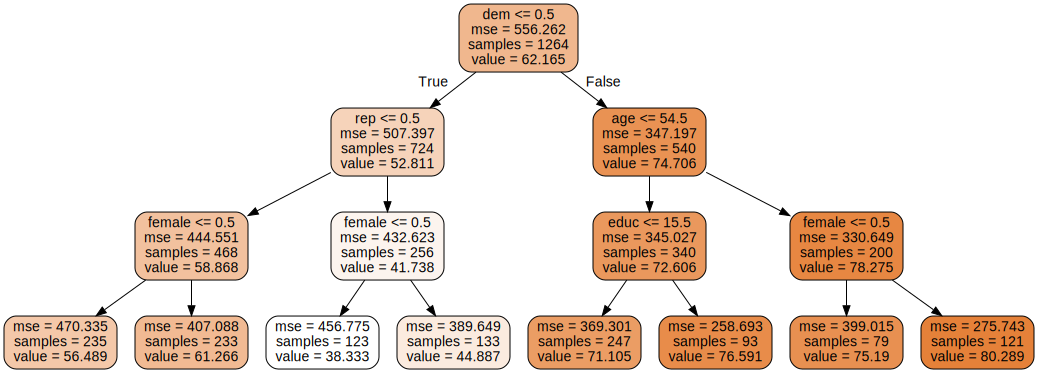

In [6]:
hit_tree2 = DecisionTreeRegressor(min_samples_leaf=5, max_depth=3)
hit_tree2.fit(X_train, y_train)
hit_tree_viz2 = export_graphviz(
    hit_tree2,
    out_file=None,
    feature_names = ['female', 'age', 'educ', 'dem', 'rep'],
    rounded=True,
    filled=True,
)

graph2 = graphviz.Source(hit_tree_viz2)
graph2.render('hit_tree_viz2')
graph2

### It seems that tree with max_dept = 3 results in the lowest MSE 396.1937146321307. This tree keeps the same prediction of important features, party affliation, age and gender, but it cut down some non-necessary feature, thus yiled a smaller MSE compared to original large tree.

# (c)

In [7]:
# n_estimators is how many samples from the data to take (the number of trees)
# max_samples is the maximum number of observations to include in each bootstrapped data sample
hit_tree_bagging = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100,
                                 max_samples=100, bootstrap=True, oob_score=True,
                                 random_state=15)
hit_tree_bagging.fit(X, y)
y_pred_bagging = hit_tree_bagging.oob_prediction_
MSE3 = mean_squared_error(y, y_pred_bagging)
print('MSE_Bagging=', MSE3)

MSE_Bagging= 406.0005583949261


In [8]:
importances = np.mean([
    tree.feature_importances_ for tree in hit_tree_bagging.estimators_
], axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
features = ['female', 'age', 'dem', 'rep', 'educ']
for f in range(len(features)):
    print(str(f+1), ". ", features[f], ": ",str(importances[indices[f]]))

1 .  female :  0.4429127039606069
2 .  age :  0.20057625971613363
3 .  dem :  0.19032354439169072
4 .  rep :  0.10602822551257896
5 .  educ :  0.06015926641898977


### Based on the bagging method, we saw that geneder is the most important variable, after than it's age and political affliation.

# (d)

In [9]:
for m in range(3):
    tree_m = RandomForestRegressor(n_estimators=200, max_features=m+1, bootstrap=True,
                                  oob_score=True, random_state=15)
    tree_m.fit(X, y)
    tree_m.score(X, y)
    y_pred_m = tree_m.oob_prediction_
    MSE_m = mean_squared_error(y, y_pred_m)
    print('For M =', m+1 ,', MSE =' , MSE_m)
    importances = tree_m.feature_importances_
    std = np.std([tree.feature_importances_ for tree in tree_m.estimators_],
             axis=0)
    indices = np.argsort(importances)[::-1]
    print("Feature ranking:")
    features = ['female', 'age', 'dem', 'rep', 'educ']
    for f in range(X.shape[1]):
        print(str(f+1), ". ", features[f], ": ",str(importances[indices[f]]))
    print()

For M = 1 , MSE = 529.4303783332053
Feature ranking:
1 .  female :  0.5162120374225649
2 .  age :  0.17548889096290413
3 .  dem :  0.14860690315036698
4 .  rep :  0.13771446848011754
5 .  educ :  0.021977699984046223

For M = 2 , MSE = 532.6164617461975
Feature ranking:
1 .  female :  0.5104639832704975
2 .  age :  0.18938228776976276
3 .  dem :  0.15159362888808126
4 .  rep :  0.1263943541482502
5 .  educ :  0.022165745923408194

For M = 3 , MSE = 526.1982592630542
Feature ranking:
1 .  female :  0.48871745601269106
2 .  age :  0.20339879959639098
3 .  dem :  0.163613417845259
4 .  rep :  0.1156262511102098
5 .  educ :  0.028644075435448686



### The same results as before, female seems to be the most important variable, age and party affliation follow. 
### m=3 produce the best MSE in this mode. Though the difference is not siginicant.